Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt
import pickle
%matplotlib inline
import matplotlib.image as mpimg

In [4]:


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images

images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
        
cv2.destroyAllWindows()


### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

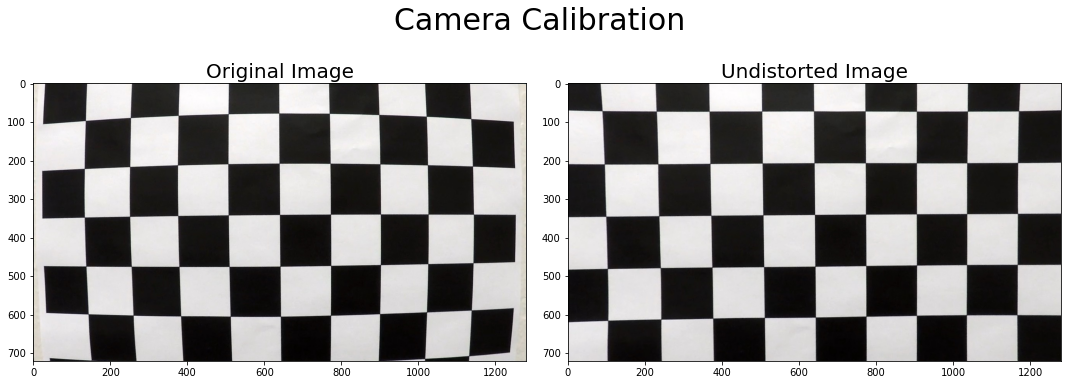

In [5]:

# Test undistortion on an image
img = mpimg.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)

cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
#dist_pickle = {}
#dist_pickle["mtx"] = mtx
#dist_pickle["dist"] = dist
#pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)


# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)

plt.suptitle('Camera Calibration', fontsize = 30)

plt.subplots_adjust(top=0.9)

#f.savefig('output_images/chessboard_calibration.jpg')

Defining a function that undistorts the images

In [6]:
# Here image input is a colour one. Check if gray required (modify shape argument)

def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist


## Perspective Transform

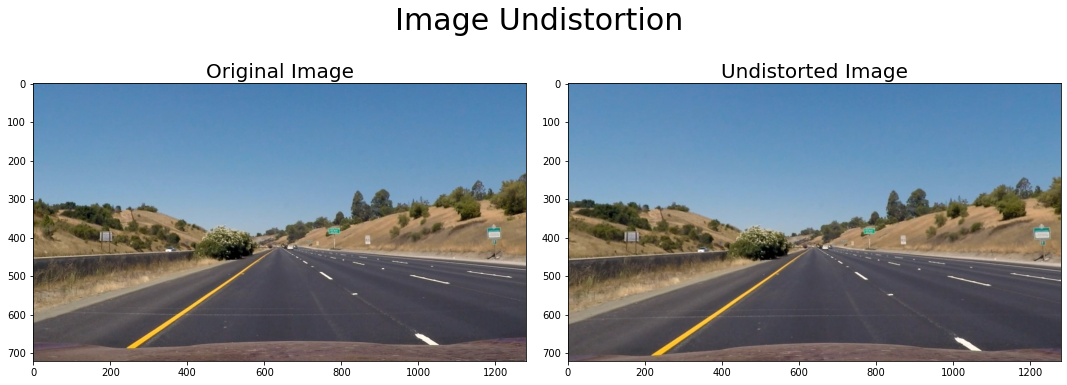

In [7]:
# Read in the saved camera matrix and distortion co-efficients
dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]


original = mpimg.imread('test_images/straight_lines1.jpg')

undist = cal_undistort(original,mtx,dist)

img=undist.copy()

imshape = img.shape

vertices = np.array([[(210,imshape[0]),(595, 450), (685, 450),(1100,imshape[0])]],dtype=np.int32)

vertices = vertices.reshape((-1, 1, 2))

##SYNTAX: cv2.polylines(image, [pts], isClosed, color, thickness)

#cv2.polylines(img, [vertices] , True, [255,0,0], thickness=2)

#cv2.imshow('image', img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(original)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(img)
ax2.set_title('Undistorted Image', fontsize=20)


plt.suptitle('Image Undistortion', fontsize = 30)

plt.subplots_adjust(top=0.9)

#f.savefig('output_images/undistortion.jpg')

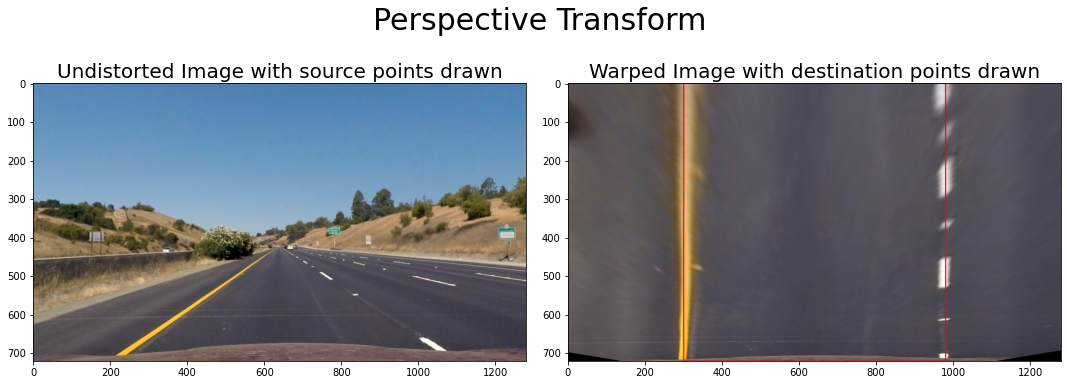

In [8]:
img_size = (img.shape[1],img.shape[0])

src=np.float32([[(210,imshape[0]),(595, 450), (685, 450),(1110,imshape[0])]])

offset=300

#dst=np.float32([[600,imshape[0]],[600,0],[690,0],[690,imshape[0]]])
dst=np.float32([[offset,imshape[0]],[offset,0],[imshape[1]-offset,0],[imshape[1]-offset,imshape[0]]])

M = cv2.getPerspectiveTransform(src, dst)

Minv = cv2.getPerspectiveTransform(dst, src)

warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)

pts = np.array([[offset,warped.shape[0]],[offset,0],[warped.shape[1]-offset,0],[warped.shape[1]-offset,warped.shape[0]]],dtype=np.int32)
cv2.polylines(warped, [pts] , True, [255,0,0], thickness=2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Undistorted Image with source points drawn', fontsize=20)
ax2.imshow(warped)
ax2.set_title('Warped Image with destination points drawn', fontsize=20)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.suptitle('Perspective Transform', fontsize = 30)

plt.subplots_adjust(top=0.9)

#f.savefig('output_images/perspective_transform.jpg')


#persp_pickle = {}
#persp_pickle["M"] = M
#persp_pickle["Minv"] = Minv
#pickle.dump( persp_pickle, open( "persp_pickle.p", "wb" ) )

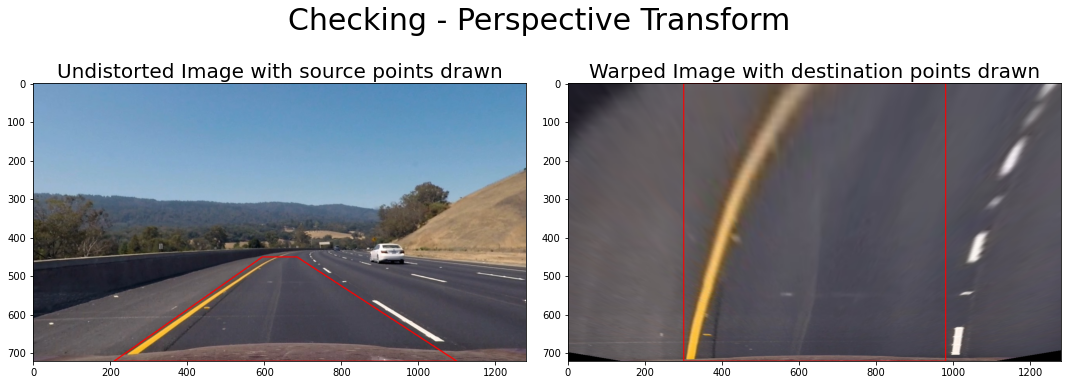

In [9]:
persp_pickle = pickle.load( open( "persp_pickle.p", "rb" ) )
G = persp_pickle["M"]


test = mpimg.imread('test_images/test3.jpg')


curved = cal_undistort(test,mtx,dist)
copy = curved.copy()

cv2.polylines(curved, [vertices] , True, [255,0,0], thickness=2)

transformed = cv2.warpPerspective(copy, G, img_size, flags=cv2.INTER_LINEAR)
cv2.polylines(transformed, [pts] , True, [255,0,0], thickness=2)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
f.tight_layout()
ax1.imshow(curved)
ax1.set_title('Undistorted Image with source points drawn', fontsize=20)
ax2.imshow(transformed)
ax2.set_title('Warped Image with destination points drawn', fontsize=20)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.suptitle('Checking - Perspective Transform', fontsize = 30)

plt.subplots_adjust(top=0.9)

#f.savefig('output_images/check_perspective_transform.jpg')